In [88]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings


# Consideraciones
- Este "notebook" se divide en las siguientes partes:
1) Observaciones iniciales; se cambian los nombres de las columnas y se borran los duplicados (cambios esenciales), además de hacer un reconocimiento general.

2) Desglose por columnas; se pasan a numéricas cuando es necesario, y se efectúa un tratamiento solo en el "dataframe" de práctica. Esos cambios se guardan en funciones y clases que luego se aplicarán según convenga en la fase de modelaje. Cada uno de estos cambios está titulado en "markdown" dentro de la columna respectiva. Las posibles modificaciones que no se ponen a prueba, por ser meras observaciones o porque alterarían demasiado el "dataframe" de práctica, se marcan como "NO EN PRUEBA". Con todo, se tienen en cuenta, pues se utilizarán tambien en la fase de modelaje.
3) Desglose por múltiples variables; idéntico al anterior, pero esta vez se trabaja con varias columnas a la vez.
4) Estandarización; solo se aplica en el "dataframe" de práctica.
5) Observaciones finales; a modo de conclusión.
6) Exportación; se hace solo con los "dataframes" con los cambios esenciales (sin duplicados, con nuevos nombres de columnas y con las variables numéricas). El de práctica solo se utiliza para el EDA.

In [89]:
# Kaggle: https://www.kaggle.com/competitions/diamonds-part-datamad0122/
# Origen: Tiffany & Co's snapshot pricelist from 2017
warnings.filterwarnings("ignore")

df_train = pd.read_csv(r'..\data\raw\train.csv')
df_test = pd.read_csv(r'..\data\raw\test.csv')

df_base = [df_train, df_test]


# Observaciones iniciales

In [90]:
df_base[0].head()


,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,0.30,Premium,D,SI2,62.4,58.0,4.31,4.28,2.68,6.353
1,1,1.01,Ideal,E,VVS2,62.7,56.0,6.42,6.46,4.04,9.183
2,2,0.72,Ideal,F,VS2,61.8,59.0,5.71,5.74,3.54,7.983
3,3,1.08,Very Good,G,SI2,63.2,57.0,6.54,6.50,4.12,8.371
4,4,0.36,Premium,G,VS1,62.3,59.0,4.50,4.55,2.82,6.588


In [91]:
# Se adaptan los nombres de las columnas para que sean legibles
for df in df_base:
    df.rename(columns={'carat': 'weight (carat)',
                        'cut': 'cut quality',
                        'color': 'color quality',
                        'clarity': 'clarity quality', # Fuente: https://4cs.gia.edu/en-us/diamond-clarity/
                        'depth': 'depth (percentage)', # Medida de la altura ("depth") del diamante en relación a su diámetro. Fuente: https://www.withclarity.com/education/diamond-education/diamond-cut/what-is-diamond-depth-or-diamond-education
                        'table': 'table (percentage)', # Medida de la parte plana ("table") del diamante en relación a su diámetro. Fuente: https://www.brilliance.com/education/diamonds/depth-table
                        'x': 'lenght (millimeters)', # Visto desde arriba, longitud de un costado del diamante. Su media con "width" da el diámetro
                        'y': 'width (millimeters)', # Visto desde arriba, longitud del otro costado
                        'z': 'depth (millimeters)' # Altura (distancia entre la punta y la parte plana)
                        }, inplace=True
                )


In [92]:
df_base[0].head()


,id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
0,0,0.30,Premium,D,SI2,62.4,58.0,4.31,4.28,2.68,6.353
1,1,1.01,Ideal,E,VVS2,62.7,56.0,6.42,6.46,4.04,9.183
2,2,0.72,Ideal,F,VS2,61.8,59.0,5.71,5.74,3.54,7.983
3,3,1.08,Very Good,G,SI2,63.2,57.0,6.54,6.50,4.12,8.371
4,4,0.36,Premium,G,VS1,62.3,59.0,4.50,4.55,2.82,6.588


In [93]:
# No hay valores nulos
df_base[0].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    40455 non-null  int64  
 1   weight (carat)        40455 non-null  float64
 2   cut quality           40455 non-null  object 
 3   color quality         40455 non-null  object 
 4   clarity quality       40455 non-null  object 
 5   depth (percentage)    40455 non-null  float64
 6   table (percentage)    40455 non-null  float64
 7   lenght (millimeters)  40455 non-null  float64
 8   width (millimeters)   40455 non-null  float64
 9   depth (millimeters)   40455 non-null  float64
 10  price                 40455 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 3.4+ MB


In [94]:
# No parece posible que haya diamantes con 0 milimetros de altura, anchura o profundidad
# Quizá lo que ocurra es que son tan redondos que no cabe medir algunos datos. Habrá que revisarlo
df_base[0].describe()


,id,weight (carat),depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
count,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000
mean,20227.000000,0.797576,61.746377,57.451694,5.729163,5.732896,3.537351,7.783822
std,11678.496907,0.475939,1.436796,2.234569,1.125244,1.154799,0.711002,1.016828
min,0.000000,0.200000,43.000000,44.000000,0.000000,0.000000,0.000000,5.787000
25%,10113.500000,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000,6.851000
50%,20227.000000,0.700000,61.800000,57.000000,5.690000,5.700000,3.520000,7.780000
75%,30340.500000,1.040000,62.500000,59.000000,6.540000,6.540000,4.030000,8.581000
max,40454.000000,5.010000,79.000000,95.000000,10.740000,58.900000,31.800000,9.842000


In [95]:
df_base[0].describe(include='object')


,cut quality,color quality,clarity quality
count,40455,40455,40455
unique,5,7,8
top,Ideal,G,SI1
freq,16230,8410,9779


In [96]:
# No hay valores duplicados
df_base[0][df_base[0].duplicated()]


,id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price


In [97]:
# Se copian los "dataframes" para poder trabajar con varias versiones si conviene
df_diamonds = df_base.copy()


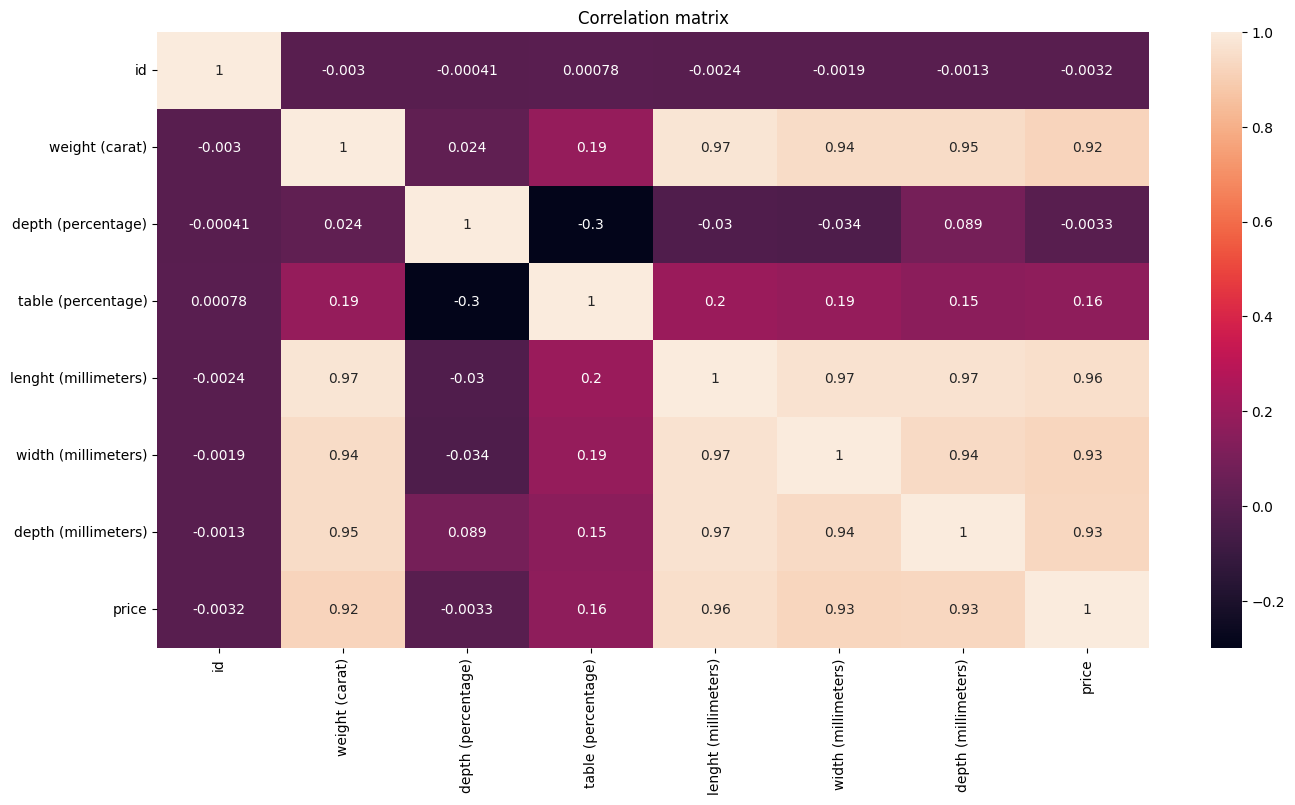

In [98]:
# Se hace una correlación preeliminar (sin análisis) que servirá para retroceder y detectar errores, si los hay, durante la limpieza
plt.rc("figure", figsize=(16, 8))

corr = df_diamonds[0].corr(numeric_only=True)
sns.heatmap(corr, annot=True)
plt.title('Correlation matrix')
plt.show()


In [99]:
# Se crea un "dataframe" de práctica para ir aplicando los cambios opcionales sin tocar el original
# Se llevarán a cabo en los tres "dataframes" solo los esenciales
plt.rc("figure", figsize=(6.4, 4.8))

df_practice = df_diamonds[0].copy().drop(columns='id')

df_practice.head()


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
0,0.30,Premium,D,SI2,62.4,58.0,4.31,4.28,2.68,6.353
1,1.01,Ideal,E,VVS2,62.7,56.0,6.42,6.46,4.04,9.183
2,0.72,Ideal,F,VS2,61.8,59.0,5.71,5.74,3.54,7.983
3,1.08,Very Good,G,SI2,63.2,57.0,6.54,6.50,4.12,8.371
4,0.36,Premium,G,VS1,62.3,59.0,4.50,4.55,2.82,6.588


# Desglose por columnas

## weight (carat)

In [100]:
df_practice['weight (carat)'].unique()


array([0.3 , 1.01, 0.72, 1.08, 0.36, 0.53, 1.74, 0.33, 0.32, 0.27, 0.63,
       0.31, 0.7 , 0.74, 1.29, 0.71, 0.52, 0.42, 1.06, 0.58, 1.5 , 1.  ,
       0.51, 1.2 , 0.41, 1.12, 1.22, 0.5 , 0.56, 2.53, 0.37, 1.7 , 0.54,
       0.34, 1.61, 0.38, 0.61, 1.21, 1.28, 1.26, 0.4 , 0.81, 0.76, 0.44,
       1.03, 0.6 , 1.1 , 0.78, 1.13, 0.77, 2.09, 0.35, 0.39, 0.9 , 1.84,
       0.79, 1.07, 1.58, 2.01, 2.  , 1.27, 1.51, 0.62, 1.68, 0.66, 1.17,
       1.56, 1.11, 0.24, 1.05, 1.65, 1.47, 2.08, 1.55, 0.55, 1.04, 1.02,
       0.43, 0.59, 0.25, 2.03, 1.25, 0.94, 1.54, 1.59, 0.26, 0.8 , 1.76,
       1.63, 1.24, 1.34, 1.52, 2.22, 0.47, 2.25, 1.39, 0.46, 0.45, 0.92,
       0.23, 1.72, 0.91, 1.53, 1.19, 0.73, 0.75, 0.29, 0.28, 1.33, 2.33,
       1.41, 1.31, 1.43, 0.93, 1.09, 1.3 , 1.73, 1.99, 1.35, 1.46, 1.71,
       1.14, 0.96, 1.15, 1.18, 1.69, 0.83, 0.57, 1.23, 2.05, 2.26, 1.6 ,
       2.12, 2.21, 2.02, 2.14, 2.06, 1.32, 1.75, 1.57, 2.74, 2.16, 2.42,
       0.97, 1.66, 1.38, 1.67, 0.65, 2.5 , 1.16, 2.

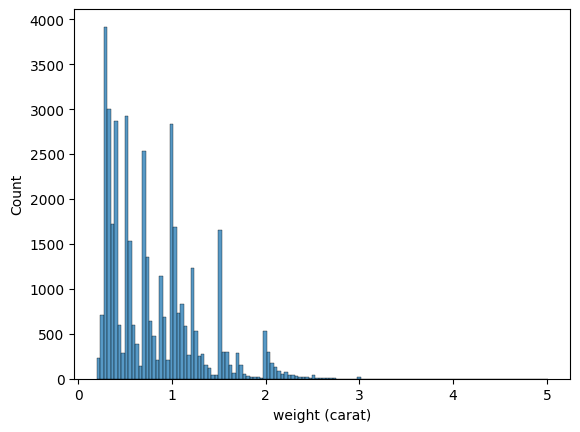

In [101]:
# Hay muy pocos diamantes que pesen más de 2 "carat" (quilates)
sns.histplot(df_practice['weight (carat)'])
plt.show()


In [102]:
# No hay valores que sean cero
df_practice[df_practice['weight (carat)'] == 0] 


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price


### Uso del logaritmo

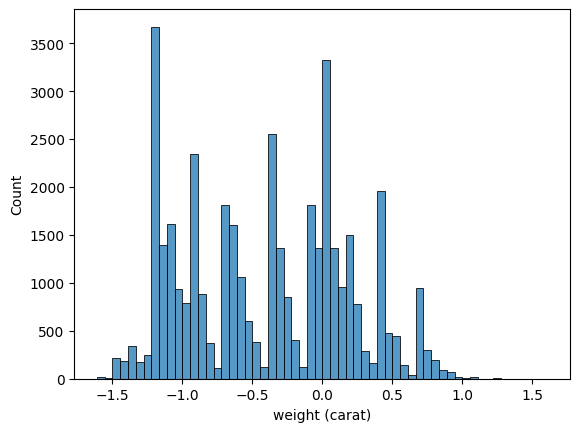

In [103]:
# Está muy a la izquierda. Puede valer la pena usar el logaritmo para centrarlo
# Como se ha anunciado, este tipo de cambios se hacen solo en el "dataframe" de práctica, con fines meramente de observación
# Asimismo, se usa "markdown" para ir señalándolos y que quede constancia de ellos por si toca aplicarlos en la fase de modelaje
df_practice['weight (carat)'] = np.log(df_practice['weight (carat)'])

sns.histplot(df_practice['weight (carat)'])
plt.show()


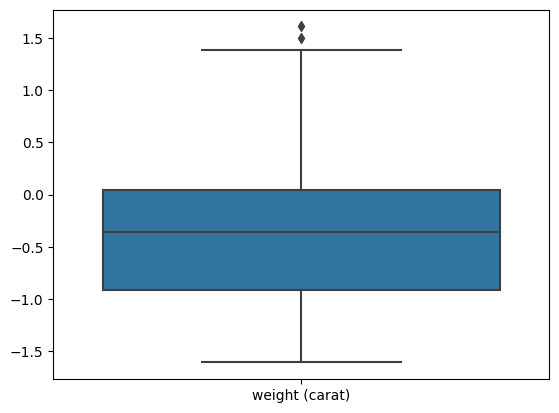

In [104]:
# Se confirma con un boxplot que así solo quedarían un par de valores atípicos
ax = sns.boxplot(df_practice['weight (carat)'])
ax.set_xticklabels(['weight (carat)'])
plt.show()


### Imputación a valores máximos del "boxplot"

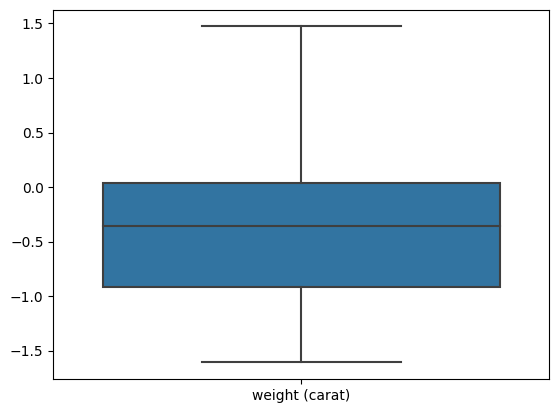

In [105]:
# Como están cerca del máximo del "boxplot", podrían imputarse a esa cifra
for column in ['weight (carat)']:
    q3, q1 = np.percentile(df_practice[column], [75, 25])
    iqr = q3 - q1
    df_practice.loc[df_practice[column] > q3 + 1.5*iqr, column] = q3 + 1.5*iqr

ax = sns.boxplot(df_practice['weight (carat)'])
ax.set_xticklabels(['weight (carat)'])
plt.show()


## cut quality

In [106]:
# No es numérica, hay que transformarla
# Como se ha señalado, este tipo de cambios son esenciales, irremediables. Por tanto, se aplican a los tres "dataframes" y no se apuntan en "markdown"
for df in (df_diamonds[0], df_diamonds[1], df_practice):
    df.loc[:, 'cut quality'] = df['cut quality'].apply(lambda x: 0 if x == 'Fair' 
                                                                    else 1 if x == 'Good'
                                                                    else 2 if x == 'Very Good'
                                                                    else 3 if x == 'Premium'
                                                                    else 4
                                                        )
    df.loc[:, 'cut quality'] = df['cut quality'].astype(float)

df_practice['cut quality'].unique()


array([3., 4., 2., 0., 1.])

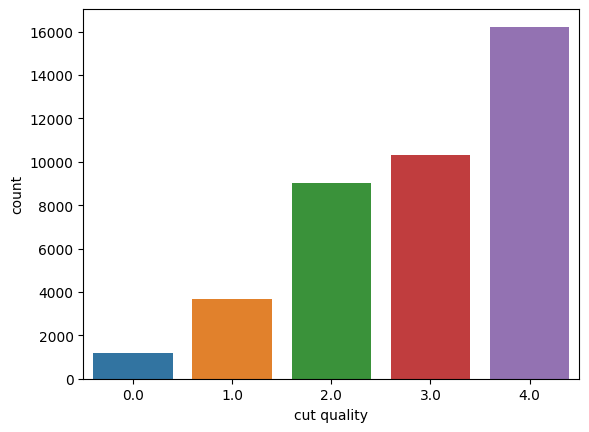

In [107]:
# Están bastente repartidos, aunque hay menos de categoría "Good" (1.0) o inferior
sns.countplot(x=df_practice['cut quality'])
plt.show()


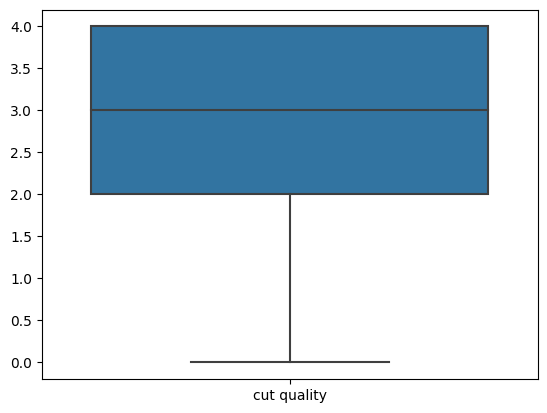

In [108]:
# En efecto, no hay "outliers"
ax = sns.boxplot(df_practice['cut quality'])
ax.set_xticklabels(['cut quality'])
plt.show()


## color quality

In [109]:
# Similar al anterior, hay que pasar los valores a numéricos (J es la peor calidad, y D es la mejor)
for df in df_diamonds[0], df_diamonds[1], df_practice:
    df.loc[:, 'color quality'] = df['color quality'].apply(lambda x: 0 if x == 'J' 
                                                    else 1 if x == 'I'
                                                    else 2 if x == 'H'
                                                    else 3 if x == 'G'
                                                    else 4 if x == 'F'
                                                    else 5 if x == 'E'
                                                    else 6)
    df.loc[:, 'color quality'] = df['color quality'].astype(float)

df_practice['color quality'].unique()


array([6., 5., 4., 3., 2., 1., 0.])

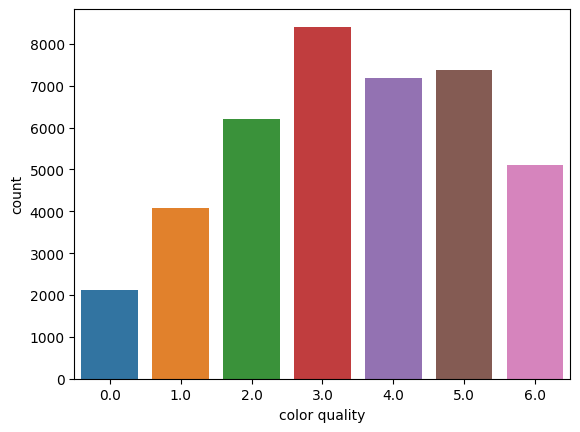

In [110]:
# Están repartidos, si bien hay pocos de calidad J (0.0)
sns.countplot(x=df_practice['color quality'])
plt.show()


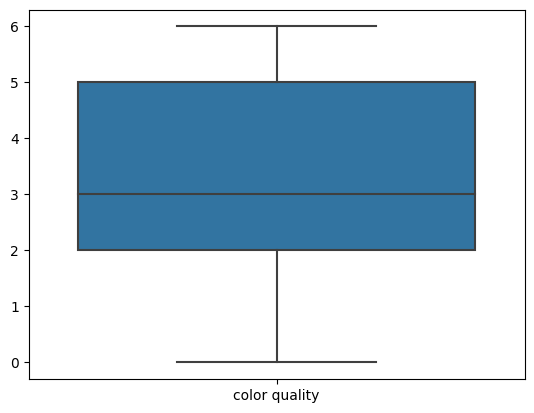

In [111]:
# Sin valores atípicos
ax = sns.boxplot(df_practice['color quality'])
ax.set_xticklabels(['color quality'])
plt.show()


## clarity quality

In [112]:
df_practice['clarity quality'].unique()


array(['SI2', 'VVS2', 'VS2', 'VS1', 'SI1', 'VVS1', 'IF', 'I1'],
      dtype=object)

In [113]:
# Hay que buscar a qué nivel de calidad corresponde cada valor y numerarlos
# Fuente: https://www.77diamonds.com/es/grados-de-pureza-del-diamante
for df in (df_diamonds[0], df_diamonds[1], df_practice):
    df.loc[:, 'clarity quality'] = df['clarity quality'].apply(lambda x: 0 if x == 'I1'
                                                                else 1 if x == 'SI2'
                                                                else 2 if x == 'SI1'
                                                                else 3 if x == 'VS2'
                                                                else 4 if x == 'VS1'
                                                                else 5 if x == 'VVS2'
                                                                else 6 if x == 'VVS1'
                                                                else 7
                                                                )
    df.loc[:, 'clarity quality'] = df['clarity quality'].astype(float)

df_practice['clarity quality'].unique()


array([1., 5., 3., 4., 2., 6., 7., 0.])

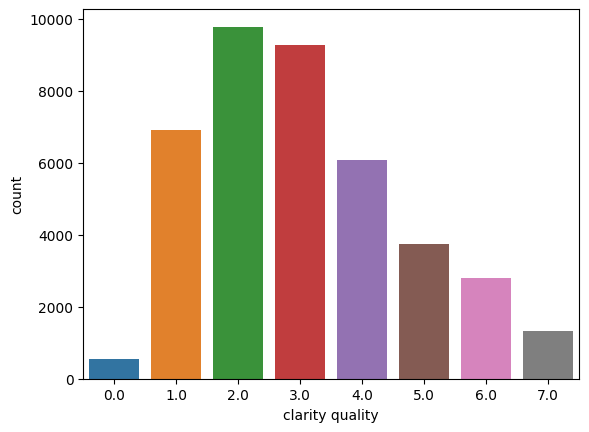

In [114]:
# Tal como indica la fuente, los diamantes de máxima calidad son muy raros. Hay menos, todavía, de la peor calidad
sns.countplot(x=df_practice['clarity quality'])
plt.show()


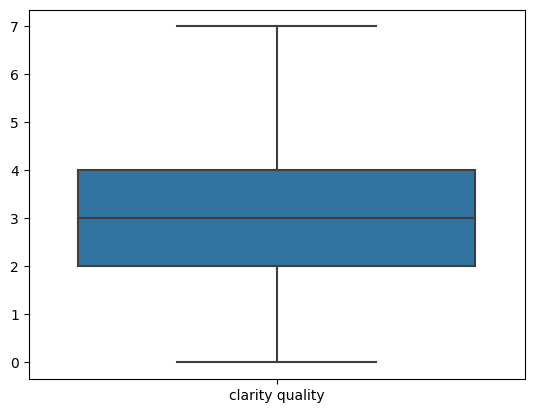

In [115]:
# Con todo, no hay "outliers"
ax = sns.boxplot(df_practice['clarity quality'])
ax.set_xticklabels(['clarity quality'])
plt.show()


## depth (percentage)

In [116]:
df_practice['depth (percentage)'].unique()


array([62.4, 62.7, 61.8, 63.2, 62.3, 61.4, 62.1, 60. , 62.9, 61.1, 62. ,
       62.2, 62.8, 61.6, 59.3, 61.7, 56.7, 65.3, 58.2, 61.9, 60.9, 61.5,
       63.4, 63.1, 64.9, 61.3, 63. , 60.6, 61.2, 59. , 62.5, 59.8, 63.3,
       61. , 63.9, 62.6, 57.2, 63.5, 60.7, 59.7, 59.1, 58.5, 58.4, 58.9,
       60.4, 59.9, 60.8, 59.2, 60.5, 60.2, 64.1, 63.6, 66.7, 59.6, 58. ,
       66.6, 58.7, 65.5, 57.7, 60.1, 64.6, 66.3, 64.2, 63.8, 58.1, 55.1,
       67.1, 64.3, 65.8, 58.8, 67. , 63.7, 59.5, 64. , 64.7, 67.4, 66.1,
       57.4, 59.4, 58.6, 60.3, 58.3, 57.3, 65. , 65.2, 64.4, 57.6, 57.8,
       65.4, 65.7, 66.4, 67.6, 64.8, 53.2, 64.5, 65.9, 65.1, 66.9, 69. ,
       66.5, 56.3, 67.2, 65.6, 68.5, 55.2, 57.9, 56.1, 56.9, 55.3, 56.5,
       55.9, 57.1, 69.7, 56.8, 57.5, 57. , 66. , 66.2, 71.8, 68.2, 55.8,
       66.8, 67.7, 68.1, 72.9, 67.8, 68.3, 68.6, 53.3, 67.3, 51. , 68. ,
       56.4, 55.5, 71. , 68.4, 53. , 56. , 54.2, 69.4, 53.8, 67.5, 56.2,
       69.2, 55.4, 70.2, 69.9, 68.8, 56.6, 72.2, 68

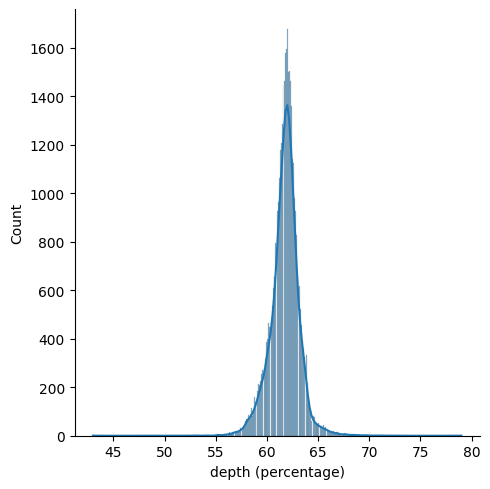

In [117]:
# Si no fuera porque el grueso de los números se encuentra en el centro y por los "huecos", se asemejaría bastante a una distribución normal
sns.displot(df_practice['depth (percentage)'], kde=True)
plt.show()


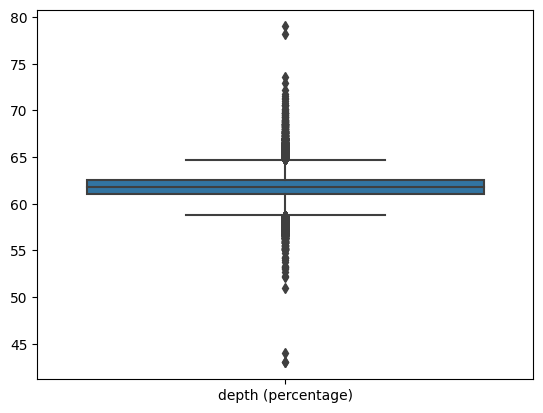

In [118]:
# A consecuencia de ello, hay muchos "outliers". Se nota la concentración en el centro
ax = sns.boxplot(df_practice['depth (percentage)'])
ax.set_xticklabels(['depth (percentage)'])
plt.show()


### Borrado de "outliers" extremadamente altos

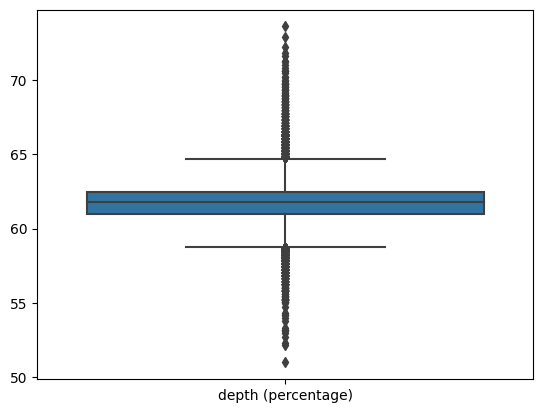

In [119]:
# Cabría liquidar esos cuatro "outliers" tremendamente altos
df_practice = df_practice.drop(df_practice[(df_practice['depth (percentage)'] > 75) | (df_practice['depth (percentage)'] < 45)].index)

ax = sns.boxplot(df_practice['depth (percentage)'])
ax.set_xticklabels(['depth (percentage)'])
plt.show()


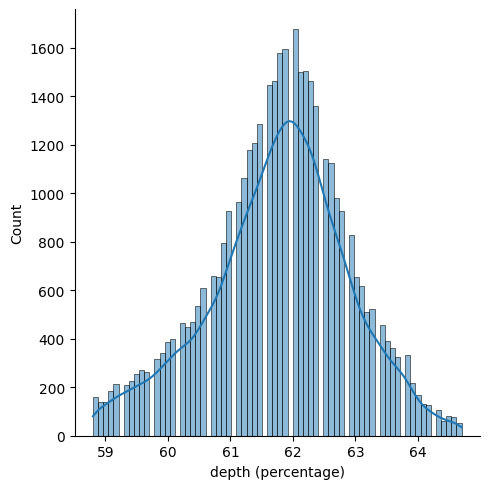

In [120]:
# Se repite la gráfica de densidad, pero, esta vez, los atípicos se filtran para una mejor visualización
# La forma recuerda a una normal, pero hay muchos valores minúsculos
q3, q1 = np.percentile(df_practice['depth (percentage)'], [75, 25])
iqr = q3 - q1

df_depth_filtered = df_practice[(df_practice['depth (percentage)'] <= q3 + 1.5*iqr) & (df_practice['depth (percentage)'] >= q1 - 1.5*iqr)]

sns.displot(df_depth_filtered['depth (percentage)'], kde=True)
plt.show()


### NO EN PRUEBA: Sustitución de valores existentes por valores calculados

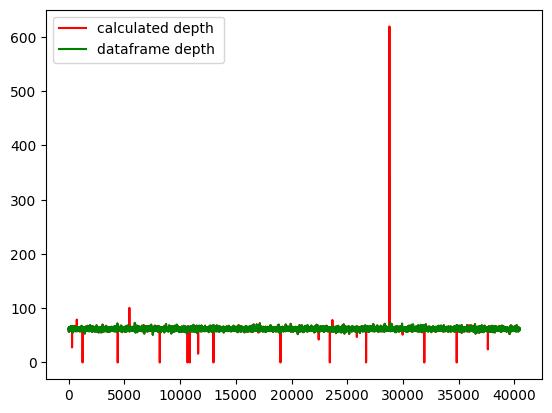

In [121]:
# Según el autor del "dataset" en Kaggle, la variable "depth (percentage)" sale de dividir "depth (millimeters)" por la media de "lenght (millimeters)" y "width (millimeters)"
# Por tanto, si se hace la operación, el resultado debería coincidir con la columna de "depth (percentage)"
# Los resultados de la operación y la versión incluida en el "dataset" no coinciden
# Para futuras pruebas de modelo, quizá convendrá tener en cuenta los valores calculados en lugar de los que vienen dados por defecto
# Sin embargo, como ello daría nuevos "outliers", no se aplica en el "dataframe" de pruebas
# Como se ha indicado, los casos como este (que no se aplican a "df_practice"), se apuntan igualmente con "markdown", pero se añade "NO EN PRUEBA" al principio
calculated_depth = (df_practice['depth (millimeters)'] / ((df_practice['lenght (millimeters)']+df_practice['width (millimeters)']) / 2)) * 100
depth_comparison = pd.DataFrame({'calculated depth ': calculated_depth, 'dataframe depth': df_practice['depth (percentage)']})

depth_comparison.plot(kind='line', color=['red', 'green'])
plt.show()


## table (percentage)

In [122]:
df_practice['table (percentage)'].unique()


array([58. , 56. , 59. , 57. , 55. , 62. , 53. , 63. , 61. , 54. , 60. ,
       64. , 65. , 55.1, 58.1, 53.6, 66. , 57.9, 68. , 56.5, 55.5, 56.6,
       55.6, 54.7, 54.8, 53.7, 54.1, 56.4, 51.6, 52. , 54.5, 57.2, 69. ,
       54.6, 54.2, 56.1, 55.9, 55.4, 59.7, 57.6, 67. , 59.9, 53.4, 60.1,
       58.2, 57.5, 53.8, 54.9, 57.8, 60.5, 56.3, 58.4, 60.3, 57.7, 60.7,
       53.5, 57.1, 61.2, 55.2, 53.9, 54.4, 56.9, 59.8, 58.6, 57.4, 59.2,
       70. , 62.4, 61.5, 55.7, 52.8, 56.8, 53.2, 61.6, 51. , 62.3, 60.2,
       49. , 57.3, 59.1, 62.5, 59.4, 55.8, 56.7, 71. , 56.2, 60.6, 55.3,
       54.3, 62.2, 62.8, 53.3, 59.5, 50.1, 59.6, 58.8, 63.4, 61.7, 65.4,
       76. , 44. , 60.4, 60.9, 61.9, 79. , 58.5, 58.9, 61.4, 50. , 61.3,
       58.3, 62.6, 53.1, 63.5, 60.8, 63.3, 61.1, 64.3, 95. , 73. , 59.3,
       58.7])

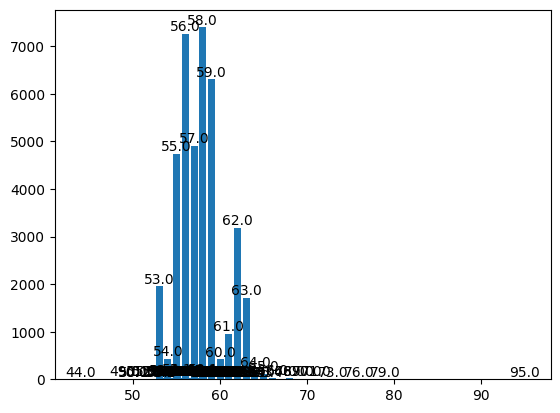

In [123]:
# La inmensa mayoría se encuentran entre 50% y 65% y hay unos pocos valores que se repiten mucho
# Se detecta un "outlier" flagrante del 95%
barplot = plt.bar(x=df_practice['table (percentage)'].unique(), height=df_practice['table (percentage)'].value_counts())
plt.bar_label(barplot, labels=df_practice['table (percentage)'].unique(), label_type='edge')
plt.show()


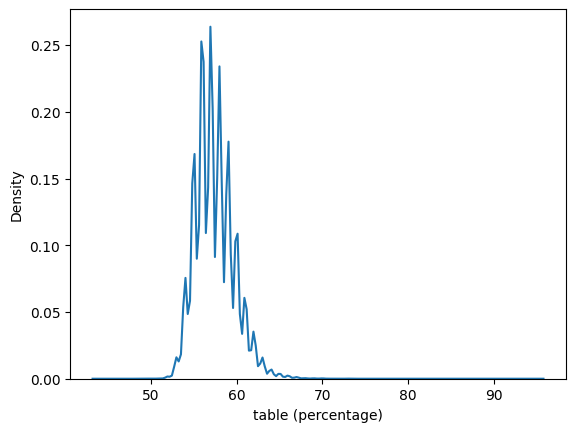

In [124]:
# Con la gráfica de densidad se ve mejor la tendencia general
sns.kdeplot(df_practice['table (percentage)'])
plt.show()


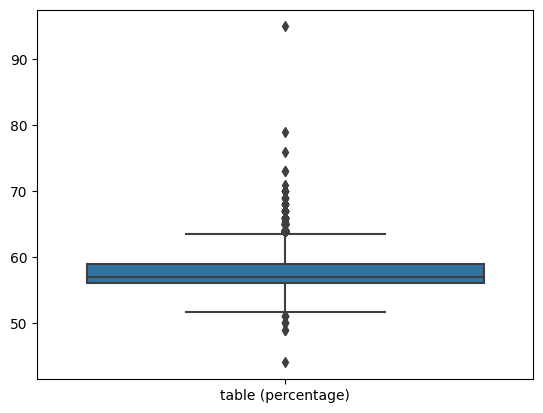

In [125]:
# Como es de preveer, hay muchos "outliers"; sobre todo, por la parte superior. Se nota la concentración importante entre 55% y 60%
ax = sns.boxplot(df_practice['table (percentage)'])
ax.set_xticklabels(['table (percentage)'])
plt.show()


### Borrado de "outliers" extremadamente altos

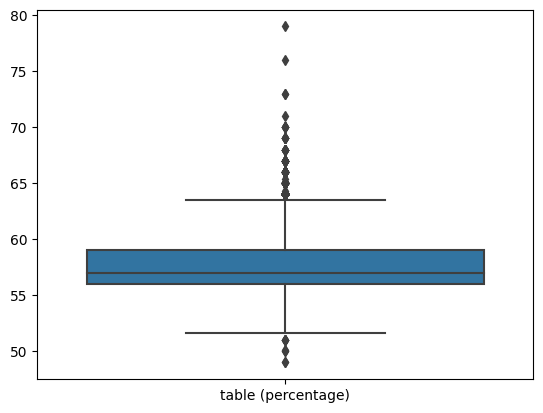

In [126]:
# Hay un par de valores muy distantes. Se eliminan
df_practice = df_practice.drop(df_practice[(df_practice['table (percentage)'] > 90) | (df_practice['table (percentage)'] < 45)].index)

ax = sns.boxplot(df_practice['table (percentage)'])
ax.set_xticklabels(['table (percentage)'])
plt.show()


## price (dollars) - target

In [127]:
# Esta es la columna "target"
df_practice['price'].unique()


array([6.353, 9.183, 7.983, ..., 7.153, 7.674, 5.852])

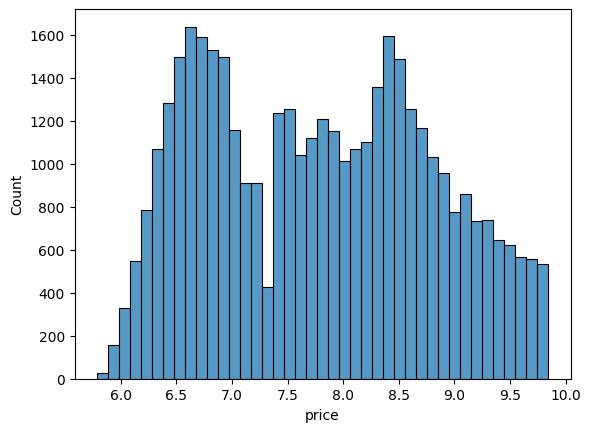

In [128]:
# Están bastante repartidos, con pocos muy caros y aún menos muy baratos
sns.histplot(df_practice['price'])
plt.show()


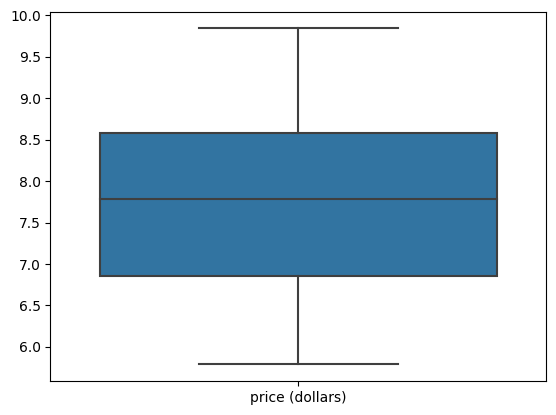

In [129]:
# No tiene valores atípicos. Al parecer, los precios ya vienen escalados para la competición
# Esto se puede comprobar echando un vistazo al "dataset" original de Kaggle: https://www.kaggle.com/datasets/shivam2503/diamonds
ax = sns.boxplot(df_practice['price'])
ax.set_xticklabels(['price (dollars)'])
plt.show()


## lenght (millimeters)

In [130]:
df_practice['lenght (millimeters)'].unique()


array([ 4.31,  6.42,  5.71,  6.54,  4.5 ,  5.18,  7.69,  4.53,  4.36,
        4.16,  5.52,  4.34,  5.2 ,  5.67,  6.89,  4.38,  4.9 ,  5.38,
        7.52,  4.33,  6.28,  5.15,  7.04,  4.78,  4.84,  6.74,  6.86,
        5.06,  5.33,  4.42,  5.77,  4.3 ,  4.44,  8.82,  6.24,  4.64,
        7.59,  4.39,  5.14,  4.52,  6.82,  5.68,  7.68,  5.69,  5.24,
        6.38,  4.32,  6.3 ,  4.61,  4.8 ,  5.84,  5.66,  5.48,  6.84,
        6.96,  6.88,  4.72,  4.29,  5.94,  5.1 ,  4.93,  5.8 ,  6.46,
        5.64,  6.59,  5.82,  6.87,  5.9 ,  5.12,  8.51,  4.55,  7.  ,
        4.45,  5.07,  5.73,  4.56,  4.37,  5.25,  4.66,  6.64,  6.97,
        6.58,  7.29,  4.69,  6.34,  6.18,  8.01,  6.08,  7.46,  6.79,
        4.4 ,  4.35,  6.8 ,  5.6 ,  6.57,  5.01,  5.3 ,  4.87,  6.6 ,
        5.22,  6.11,  5.46,  7.02,  4.77,  4.49,  6.51,  7.55,  8.27,
        8.09,  6.94,  7.2 ,  5.16,  7.4 ,  5.51,  7.83,  5.21,  5.11,
        6.37,  6.15,  7.32,  6.72,  7.28,  6.14,  5.76,  7.39,  5.19,
        5.61,  6.62,

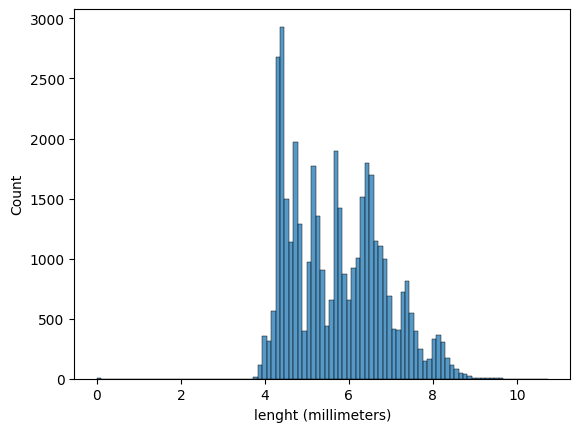

In [131]:
# Hay muchos valores únicos, así que se recurre a un histograma
# Claramente ese valor cercano a cero es un "outlier"
# Hay, además, unos pocos valores muy altos, cercanos a 10
sns.histplot(df_practice['lenght (millimeters)'])
plt.show()


In [132]:
# Si se miran los ceros, salvo uno, tampoco tienen "width" ni "depth" en milímetros
df_practice[df_practice['lenght (millimeters)'] == 0]


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
3185,0.182322,3.0,6.0,6.0,62.1,59.0,0.0,0.00,0.0,9.661
4057,-0.342490,1.0,4.0,1.0,64.1,60.0,0.0,0.00,0.0,7.664
7910,0.000000,2.0,2.0,3.0,63.3,53.0,0.0,0.00,0.0,8.545
8820,0.810930,3.0,2.0,1.0,62.8,59.0,0.0,0.00,0.0,9.800
13711,0.444686,4.0,3.0,3.0,62.2,54.0,0.0,0.00,0.0,9.457
30214,-0.342490,1.0,4.0,1.0,64.1,60.0,0.0,0.00,0.0,7.664
34815,0.067659,4.0,4.0,1.0,61.6,56.0,0.0,6.62,0.0,8.508


### Borrado de filas con 0 en las variables de milimetros para "lenght", "width" y "depth"

In [133]:
# Como esas tres variables son probablemente las que más influyen en el precio, cabe liquidarlas
df_practice = df_practice.drop(df_practice[(df_practice['lenght (millimeters)'] == 0) 
                                            & (df_practice['width (millimeters)'] == 0)
                                            & (df_practice['depth (millimeters)'] == 0)
                                            ].index
                                    )

df_practice[df_practice['lenght (millimeters)'] == 0]


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
34815,0.067659,4.0,4.0,1.0,61.6,56.0,0.0,6.62,0.0,8.508


### NO EN PRUEBA: tratamiento de los ceros en las columnas de tamaño del "test"

In [134]:
# Hay dos del "test" donde solo falta el depth, y uno donde faltan todos
# Como están en el "test", en principio no conviene tocarlos
# Sin embargo, podria valer imputarlos (las dos últimas calculándolas a partir de los otros valores relativos al tamaño; la primera, por otras vías)
df_diamonds[1][df_diamonds[1]['depth (millimeters)'] == 0]


,id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters)
8786,8786,1.14,0.0,3.0,4.0,57.5,67.0,0.00,0.00,0.0
8876,8876,1.15,4.0,3.0,3.0,59.2,56.0,6.88,6.83,0.0
10219,10219,1.00,3.0,3.0,1.0,59.1,59.0,6.55,6.48,0.0


In [135]:
# En cuanto al restante del "dataframe" de práctica, se comprueba la relación entre las columnas "lenght" y "width"
# Como los diamantes son más o menos circulares, a priori, los números de "lenght" y "width" se asemejan
# Fuente: https://www.diamondonnet.com/knowledges/help?sword=Length%20To%20Width%20Ratio
df_practice[['lenght (millimeters)','width (millimeters)']].head()


,lenght (millimeters),width (millimeters)
0,4.31,4.28
1,6.42,6.46
2,5.71,5.74
3,6.54,6.50
4,4.50,4.55


In [136]:
# Tanto es así que, excluyendo ese con cero y redondeados, son exactamente iguales todos
all(df_practice['lenght (millimeters)'].drop(34815).apply(lambda x: round(x))) == all(df_practice['width (millimeters)'].drop(34815).apply(lambda x: round(x)))


True

### Asignación de "lenght" a partir del "width" (valor 0)

In [137]:
# Se da por hecho, pues, que para ese diamante con cero ocurriría lo mismo, y que el cero es un error
# Por tanto, cabría asignarle la cifra correspondiente de la columna "width"
# Quedaría el "depth" de 0, pero se revisará más adelante
df_practice.loc[df_practice.index == 34815, 'lenght (millimeters)'] = 6.62

0 in df_practice['lenght (millimeters)'].unique()


False

### Uso del logaritmo

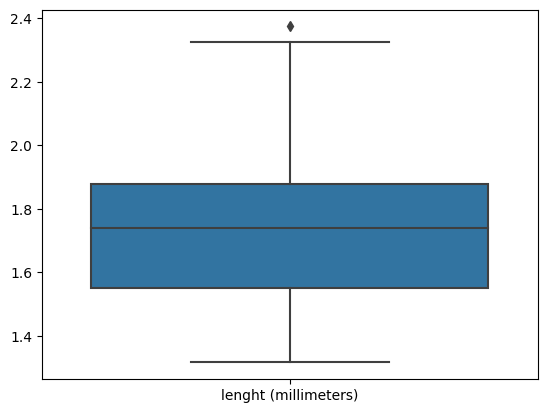

In [138]:
# Seguidamente, cabe aplicar el logaritmo
# Con ello no quedarían "outliers" por debajo de la mediana, y habría uno solo por encima
df_practice['lenght (millimeters)'] = np.log(df_practice['lenght (millimeters)'])

ax = sns.boxplot(df_practice['lenght (millimeters)'])
ax.set_xticklabels(['lenght (millimeters)'])
plt.show()


In [139]:
# El valor atípico sería este
q3, q1 = np.percentile(df_practice['lenght (millimeters)'], [75, 25])
iqr = q3 - q1

df_practice[df_practice['lenght (millimeters)'] > q3 + 1.5*iqr]


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
6403,1.472488,0.0,0.0,0.0,65.5,59.0,2.373975,10.54,6.98,9.799


### Asignación de "lenght" a partir del "width" ("outlier")

In [140]:
# Como ya se ha mencionado, por lo general, al tratarse de diamantes prácticamente circulares, el "lenght" y el "width" suelen ser muy parecidos
# Por tanto, se imputaría ese valor atípico de "lenght" al "width" correspondiente
q3, q1 = np.percentile(df_practice['lenght (millimeters)'], [75, 25])
iqr = q3 - q1

df_practice.loc[df_practice['lenght (millimeters)'] > q3 + 1.5*iqr, 'lenght (millimeters)'] = np.log(10.54)

df_practice[df_practice['lenght (millimeters)'] > q3 + 1.5*iqr]


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price


## width (millimeters)

In [141]:
df_practice['width (millimeters)'].unique()


array([ 4.28,  6.46,  5.74,  6.5 ,  4.55,  5.2 ,  7.63,  4.56,  4.39,
        4.12,  5.58,  4.37,  5.15,  5.72,  5.76,  6.93,  4.41,  5.22,
        4.92,  5.4 ,  7.57,  4.35,  6.25,  5.17,  6.95,  4.75,  4.8 ,
        6.66,  6.8 ,  4.31,  5.28,  4.46,  5.81,  6.51,  4.32,  4.45,
        8.76,  6.31,  4.6 ,  7.64,  4.34,  5.1 ,  4.57,  6.87,  5.75,
        6.83,  7.6 ,  5.73,  5.26,  6.35,  4.29,  6.38,  4.67,  4.77,
        5.8 ,  5.53,  6.9 ,  6.84,  4.66,  5.98,  4.38,  5.13,  5.87,
        4.88,  5.82,  6.43,  5.37,  5.67,  6.67,  5.7 ,  6.79,  5.85,
        5.08,  8.46,  4.52,  6.98,  4.43,  5.11,  4.27,  4.5 ,  5.23,
        4.69,  6.61,  7.01,  6.55,  7.19,  4.73,  6.44,  6.11,  7.98,
        6.06,  6.68,  4.4 ,  6.75,  5.63,  6.53,  4.48,  4.74,  5.07,
        5.12,  5.33,  4.84,  6.58,  6.02,  5.49,  6.96,  4.81,  7.5 ,
        8.2 ,  8.12,  7.16,  7.37,  5.46,  7.72,  5.24,  6.34,  6.99,
        5.14,  4.44,  5.38,  6.19,  7.27,  6.77,  7.32,  6.2 ,  7.46,
        5.65,  6.85,

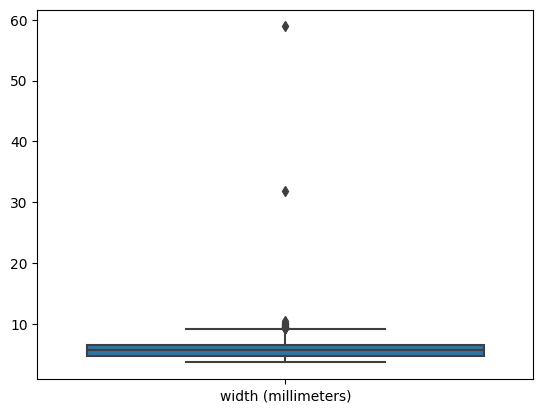

In [142]:
# En este caso están extremadamente concentrados, si bien hay unos pocos valores superiores a 10
ax = sns.boxplot(df_practice['width (millimeters)'])
ax.set_xticklabels(['width (millimeters)'])
plt.show()


### Borrado de "outliers" extremadamente altos

In [143]:
# Hay dos valores exageradamente altos. Se borran. Con los resueltos antes en "lenght", ya no quedarían ceros tampoco en "width"
df_practice = df_practice.drop(df_practice[(df_practice['width (millimeters)'] > 30)].index)

df_practice[df_practice['width (millimeters)'] == 0]


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price


### Uso del logaritmo

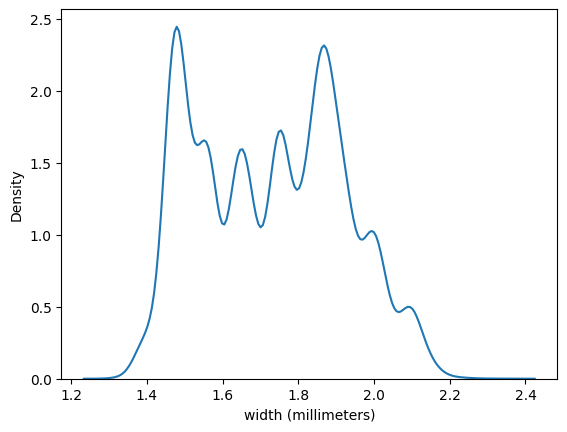

In [144]:
# Asimismo, cabría aplicar el logaritmo para desplazar la distribución y reducir los números
df_practice['width (millimeters)'] = np.log(df_practice['width (millimeters)'])

sns.kdeplot(df_practice['width (millimeters)'])
plt.show()


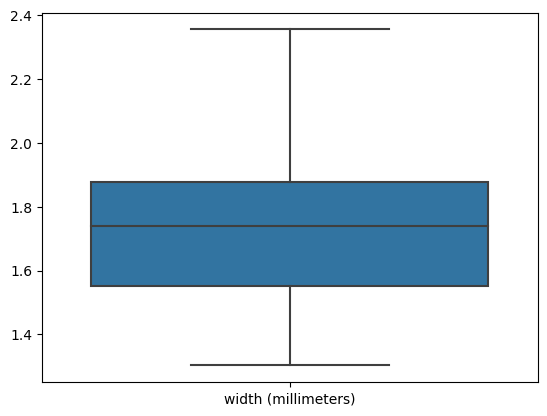

In [145]:
# Con lo hecho, ya no quedarían valores atípicos
ax = sns.boxplot(df_practice['width (millimeters)'])
ax.set_xticklabels(['width (millimeters)'])
plt.show()


## depth (millimeters)

In [146]:
df_practice['depth (millimeters)'].unique()


array([ 2.68,  4.04,  3.54,  4.12,  2.82,  3.19,  4.76,  2.72,  2.75,
        2.56,  3.39,  2.67,  3.21,  3.58,  4.34,  3.56,  2.74,  3.2 ,
        2.91,  4.02,  3.36,  4.28,  2.69,  4.09,  3.17,  4.07,  2.97,
        4.15,  4.24,  3.11,  2.7 ,  3.26,  3.57,  4.14,  3.55,  5.37,
        2.83,  4.71,  3.5 ,  4.23,  4.51,  2.77,  3.23,  3.98,  2.66,
        3.59,  3.53,  3.29,  4.31,  2.93,  2.65,  3.7 ,  3.61,  2.99,
        4.05,  3.32,  3.68,  3.27,  4.85,  2.85,  4.27,  3.49,  2.64,
        3.24,  2.87,  4.06,  4.55,  2.89,  4.  ,  3.82,  4.77,  4.58,
        4.1 ,  4.26,  3.02,  2.9 ,  3.85,  3.34,  2.84,  2.76,  3.92,
        4.59,  4.93,  2.71,  4.3 ,  3.13,  3.41,  4.6 ,  3.22,  4.03,
        3.16,  3.44,  4.01,  3.3 ,  2.95,  3.83,  4.53,  4.16,  4.47,
        3.81,  3.52,  4.63,  3.18,  4.11,  4.29,  2.51,  2.94,  4.65,
        3.74,  3.71,  4.64,  5.02,  4.62,  3.48,  3.42,  3.96,  4.19,
        4.5 ,  3.  ,  3.99,  4.54,  3.51,  2.98,  2.96,  3.07,  2.6 ,
        3.66,  3.38,

In [147]:
# Se empieza por comprobar los ceros. Hay bastantes
df_practice[df_practice['depth (millimeters)'] == 0]


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
1249,0.810930,3.0,1.0,2.0,61.3,58.0,2.142416,2.130610,0.0,9.642
4401,0.095310,3.0,3.0,1.0,63.0,59.0,1.871802,1.867176,0.0,8.215
8174,0.009950,3.0,4.0,1.0,59.2,58.0,1.871802,1.867176,0.0,8.252
10669,0.405465,1.0,3.0,0.0,64.0,61.0,1.967112,1.951608,0.0,8.462
10881,0.009950,3.0,2.0,0.0,58.1,59.0,1.896119,1.887070,0.0,8.061
12992,0.703098,3.0,2.0,3.0,62.7,53.0,2.081938,2.073172,0.0,9.810
19007,1.029619,1.0,3.0,1.0,63.8,58.0,2.186051,2.180417,0.0,9.841
23431,0.788457,3.0,2.0,2.0,61.2,59.0,2.130610,2.124654,0.0,9.756
26686,0.113329,3.0,3.0,0.0,60.4,59.0,1.903599,1.897620,0.0,7.776
31910,0.779325,3.0,2.0,1.0,59.4,61.0,2.138889,2.134166,0.0,9.444


### Asignación del "depth (millimeters)" a partir del "lenght", el "width" y el "depth (percentage)"

In [148]:
# El "depth (percentage)" se obtiene de dividir su altura total ("depth") por el diámetro
# Con el "lenght" y el "width", el diámetro se obtendría con la media de esas dos cifras
# Por tanto, se pueden solventar esos ceros con una operación
df_practice.loc[df_practice['depth (millimeters)'] == 0, 'depth (millimeters)'] = df_practice['depth (percentage)'] / 100 * (df_practice['lenght (millimeters)']+df_practice['width (millimeters)']) / 2

df_practice[df_practice['depth (millimeters)'] == 0]


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price


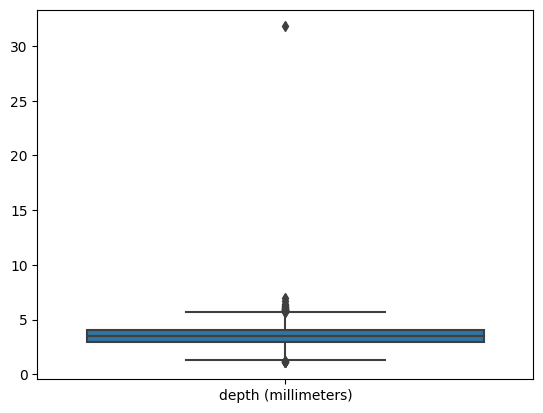

In [149]:
# Ya no habría ceros, pero los valores estarían concentrados y con varios "outliers"; uno de ellos, muy alto
ax = sns.boxplot(df_practice['depth (millimeters)'])
ax.set_xticklabels(['depth (millimeters)'])
plt.show()


### Borrado de "outliers" extremadamente altos

In [150]:
# Se liquida ese valor tan alto
df_practice = df_practice.drop(df_practice[df_practice['depth (millimeters)'] > 30].index)


### Uso del logaritmo

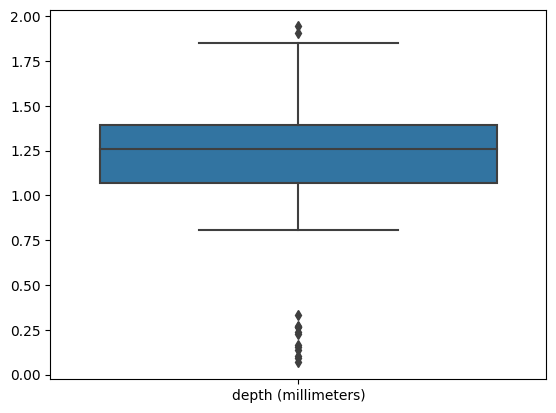

In [151]:
# Luego, se aplica el logaritmo
# Seguiría habiendo "outliers", pero se mirarán más adelante
df_practice['depth (millimeters)'] = np.log(df_practice['depth (millimeters)'])

ax = sns.boxplot(df_practice['depth (millimeters)'])
ax.set_xticklabels(['depth (millimeters)'])
plt.show()


# Desglose por múltiples variables

In [152]:
df_practice.head()


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
0,-1.203973,3.0,6.0,1.0,62.4,58.0,1.460938,1.453953,0.985817,6.353
1,0.009950,4.0,5.0,5.0,62.7,56.0,1.859418,1.865629,1.396245,9.183
2,-0.328504,4.0,4.0,3.0,61.8,59.0,1.742219,1.747459,1.264127,7.983
3,0.076961,2.0,3.0,1.0,63.2,57.0,1.877937,1.871802,1.415853,8.371
4,-1.021651,3.0,3.0,4.0,62.3,59.0,1.504077,1.515127,1.036737,6.588


In [153]:
# La cuestión de los ceros en las columnas relativas al tamaño del diamante quedaría resuelta
df_practice.describe()


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
count,40439.000000,40439.000000,40439.000000,40439.000000,40439.000000,40439.000000,40439.000000,40439.000000,40439.000000,40439.000000
mean,-0.396497,2.907911,3.407997,3.048592,61.746829,57.451089,1.726808,1.727377,1.244329,7.783612
std,0.585889,1.116147,1.703587,1.646452,1.423072,2.224241,0.194131,0.192707,0.194916,1.016779
min,-1.609438,0.000000,0.000000,0.000000,51.000000,49.000000,1.316408,1.302913,0.067659,5.787000
25%,-0.916291,2.000000,2.000000,2.000000,61.000000,56.000000,1.549688,1.551809,1.068153,6.851000
50%,-0.356675,3.000000,3.000000,3.000000,61.800000,57.000000,1.738710,1.740466,1.258461,7.779000
75%,0.039221,4.000000,5.000000,4.000000,62.500000,59.000000,1.877937,1.877937,1.393766,8.581000
max,1.472488,4.000000,6.000000,7.000000,73.600000,79.000000,2.355178,2.355178,1.943049,9.842000


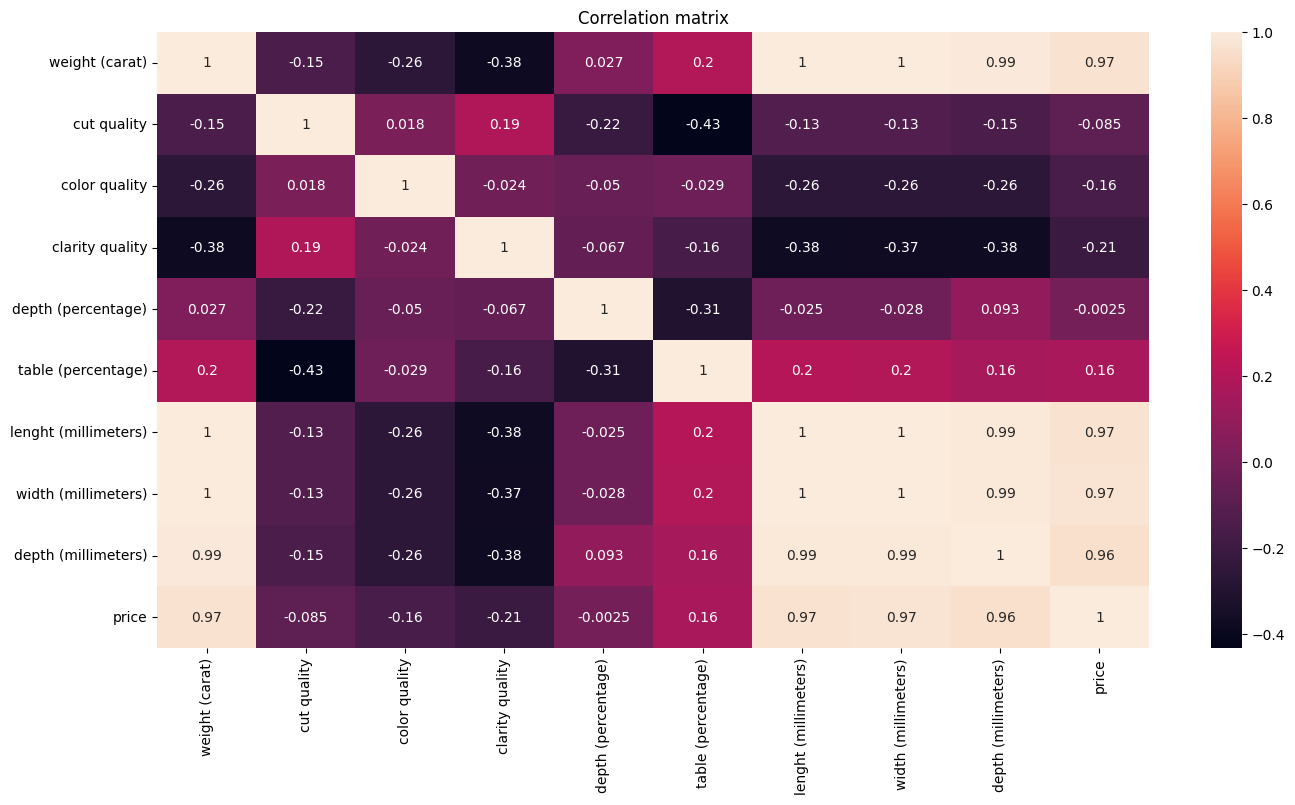

In [154]:
# Parece que lo que más influye en el precio son el tamaño ("lenght", "width" y "depth") y el peso ("weight") del diamante
# Respecto a las medidas específicas para diamantes ("depth" y "table" en %), se supone que mejorar en una suele requerir sacrificar la otra
# Eso a se debería que la "table" (parte plana superior del diamante) es más grande en los diamantes más anchos, y no en los de mayor altura ("depth")
# Asimismo, a mayor tamaño se pierde claridad (probablemente porque, con una mayor superficie, hay mayor posibilidad de imperfecciones)
# Hay otra correlación negativa entre la calidad del corte y el tamaño de la tabla, quizá porque cuanto mayor es la tabla más perceptibles son los cortes
# Habrá que tener en cuenta al comparar que varias variables se han escalado
plt.rc("figure", figsize=(16, 8))

corr = df_practice.corr(numeric_only=True)
sns.heatmap(corr, annot=True)
plt.title('Correlation matrix')
plt.show()


In [155]:
plt.rc("figure", figsize=(6.4, 4.8))


## weight (carat), lenght (millimeters), width (millimeters), depth (millimeters) & price (dollars)

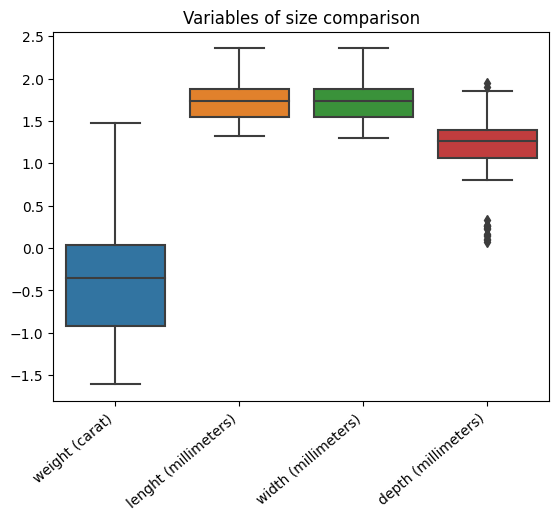

In [156]:
# Las cuatro primeras variables del título, las que vendrían a indicar el tamaño y el peso del diamante, están altísimamente correlacionadas
# Solo "depth" tiene "outliers"

items_list = ['weight (carat)', 'lenght (millimeters)', 'width (millimeters)', 'depth (millimeters)']
df_size = df_practice[items_list]

ax = sns.boxplot(df_size)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title('Variables of size comparison')
plt.show()


### Imputación de "outliers" mediante un modelo "ridge"

In [157]:
# Cabría utilizar un modelo de regresión para predecir esos "outliers" e imputarlos
# Como la correlación es tan extremadamente alta que podría decirse que son prácticamente la misma variable escalada, se usaría un modelo "ridge"
q3, q1 = np.percentile(df_size['depth (millimeters)'], [75, 25])
iqr = q3 - q1

y_test = df_size[(df_size['depth (millimeters)'] > q3 + 1.5*iqr) | (df_size['depth (millimeters)'] < q1 - 1.5*iqr)]['depth (millimeters)']
y_train = df_size.drop(y_test.index)['depth (millimeters)']

X_train = df_size.drop(y_test.index)[['weight (carat)', 'lenght (millimeters)', 'width (millimeters)']]
X_test = df_size[(df_size['depth (millimeters)'] > q3 + 1.5*iqr) | (df_size['depth (millimeters)'] < q1 - 1.5*iqr)][['weight (carat)', 'lenght (millimeters)', 'width (millimeters)']]

ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

df_depth = pd.DataFrame(data={'Original depth': y_test, 'Predicted depth': y_pred})

df_depth


,Original depth,Predicted depth
1249,0.269785,1.636209
4401,0.163630,1.417624
6403,1.943049,1.855658
7978,1.905088,1.873373
8174,0.101417,1.373873
10669,0.226331,1.525884
10881,0.094416,1.361228
11619,0.067659,1.391181
12992,0.264383,1.613806
19007,0.331390,1.723095


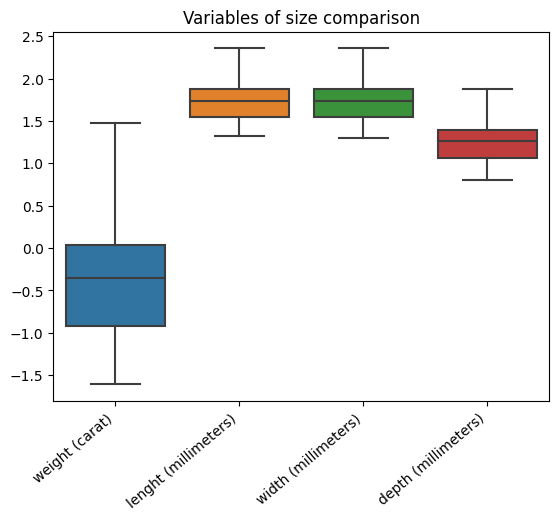

In [158]:
# Los valores atípicos de "depth" quedarían neutralizados
for index in df_depth.index:
    df_practice.loc[index, 'depth (millimeters)'] = df_depth.loc[index, 'Predicted depth']

ax = sns.boxplot(df_practice[items_list])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title('Variables of size comparison')
plt.show()


### NO EN PRUEBA: borrado de variables con altísima correlación

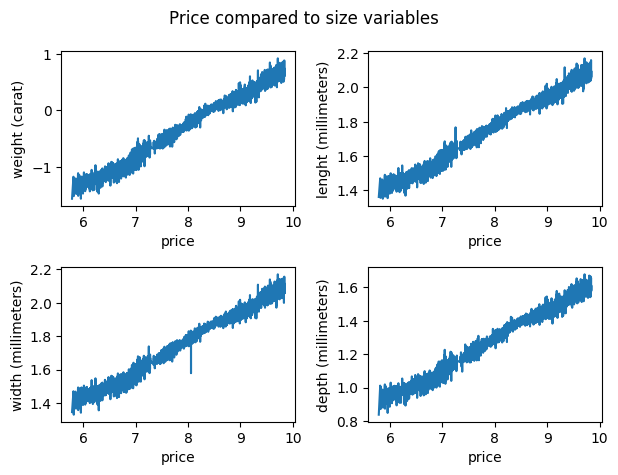

In [159]:
# Se compara el precio con cada una de las variables relacionadas con el tamaño
# Se aplica "errorbar=None" para que no compute los intervalos de confianza y sea más rápido
# Se percibe que, efectivamente, suben progresivamente con el precio de un modo similar
# Por esta razón, y teniendo en cuenta la alta correlación, cabría eliminarlas
# Sin embargo, como hay que seguir investigando, se dejan tal cual para el "dataframe" de práctica
items_list.append('price')

for index, element in enumerate(items_list[:-1], 1):
    plt.subplot(2, 2, index)
    sns.lineplot(data=df_practice, x=items_list[-1], y=element, errorbar=None)
    plt.legend('',frameon=False)
    plt.xlabel(xlabel=items_list[-1])
    plt.ylabel(ylabel=element)
plt.suptitle('Price compared to size variables')
plt.tight_layout()
plt.show()


## clarity quality, weight (carat), lenght (millimeters), width (millimeters) & depth (millimeters)

In [160]:
# La claridad del diamante (la falta de imperfecciones) tiene una importante correlación inversa (la misma) con cada una de las variables relacionadas con el tamaño
# Como las cuatro se comportan de un modo similar, para ver la tendencia es razonable simplificarlas en una sola
df_practice['size'] = (df_practice['weight (carat)'] 
                        + df_practice['lenght (millimeters)'] 
                        + df_practice['width (millimeters)'] 
                        + df_practice['depth (millimeters)']) / 4

df_practice['size'].unique()


array([0.67418373, 1.28281061, 1.10632522, ..., 1.15639622, 1.27780321,
       1.41053121])

### NO EN PRUEBA: imputación de los valores 7 de "clarity quality" al 6

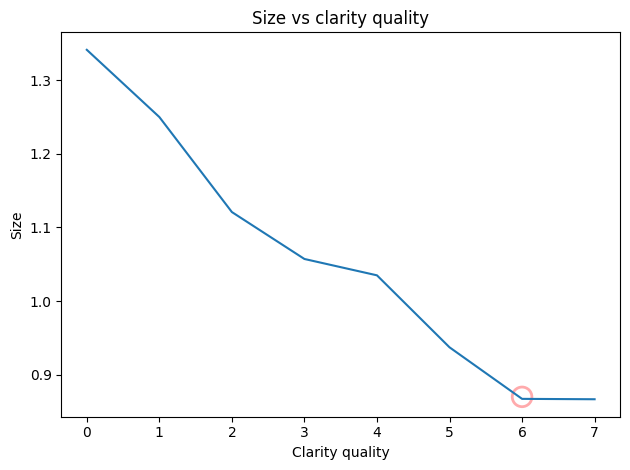

In [161]:
# Excepto con los de mayor "clarity quality", el tamaño es cada vez más reducido
# Para futuras pruebas del modelo, cabría considerar la posibilidad de imputar los de calidad 7, que son pocos, al 6, con tal de que la tendencia se mantenga
fig, ax = plt.subplots()
ax.scatter(6, 0.87, s=200, edgecolor='#ff575a', lw=2, facecolor='none', alpha=0.5, zorder=1)
sns.lineplot(y=df_practice['size'], x=df_practice['clarity quality'], errorbar=None)
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel(ylabel='Size')
plt.xlabel(xlabel='Clarity quality')
plt.title('Size vs clarity quality')
plt.tight_layout()
plt.show()


In [162]:
df_practice = df_practice.drop(columns='size')


## table (percentage) & depth (percentage)

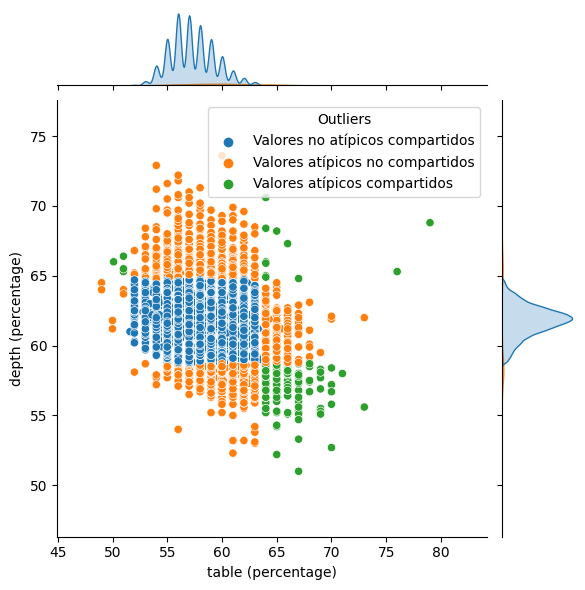

In [163]:
# La correlación más relevante de "table" es su correlación inversa con "depth (percentage)"
# Por tanto, para investigar sus valores atípicos se estudian a la vez
df_practice['Outliers'] = 'Valores no atípicos compartidos'

q3_table, q1_table = np.percentile(df_practice['table (percentage)'], [75, 25])
iqr_table = q3_table - q1_table
df_practice.loc[((df_practice['table (percentage)'] > q3_table + 1.5*iqr_table) | (df_practice['table (percentage)'] < q1_table - 1.5*iqr_table)), 'Outliers'] = 'Valores atípicos no compartidos'

q3_depth, q1_depth = np.percentile(df_practice['depth (percentage)'], [75, 25])
iqr_depth = q3_depth - q1_depth
df_practice.loc[((df_practice['depth (percentage)'] > q3_depth + 1.5*iqr_depth) | (df_practice['depth (percentage)'] < q1_depth - 1.5*iqr_depth)), 'Outliers'] = 'Valores atípicos no compartidos'

df_practice.loc[((df_practice['table (percentage)'] > q3_table + 1.5*iqr_table) | (df_practice['table (percentage)'] < q1_table - 1.5*iqr_table))
                & ((df_practice['depth (percentage)'] > q3_depth + 1.5*iqr_depth) | (df_practice['depth (percentage)'] < q1_depth - 1.5*iqr_depth)), 'Outliers'] = 'Valores atípicos compartidos'

sns.jointplot(data=df_practice, x='table (percentage)', y='depth (percentage)', hue='Outliers')
plt.show()


### Borrado de "outliers" compartidos ("depth" y "table", en porcentaje) moderadamente altos

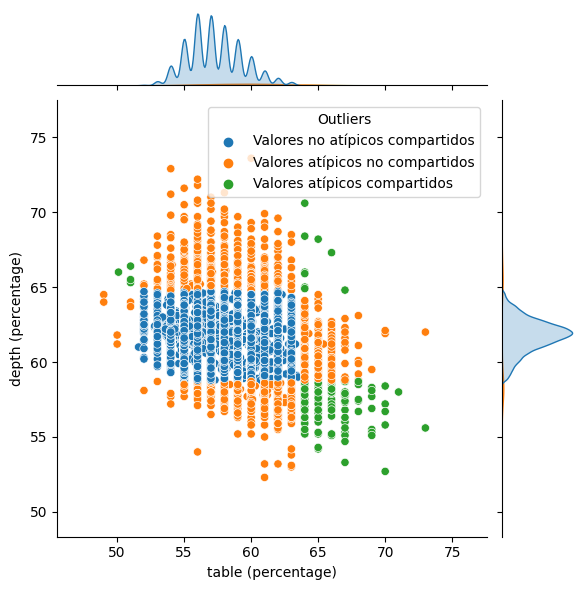

In [164]:
# Se eliminan esos "outliers" compartidos que están muy alejados del resto del conjunto (por encima de cualquier no compartido) y se repite la gráfica
df_practice = df_practice.drop(df_practice[(df_practice['table (percentage)'] > 75) | (df_practice['depth (percentage)'] < 52.3)].index)

sns.jointplot(data=df_practice, x='table (percentage)', y='depth (percentage)', hue='Outliers')
plt.show()


In [165]:
# Respecto a los compartidos, se trata de:
# a) los diamantes con mayor tabla y mayor profundidad (algunos);
# b) los diamantes con mayor tabla y menor profundidad (muchos);
# y c) los diamantes con menor tabla y mayor profundidad (pocos)
print(f"""Nº valores atípicos compartidos: {len(df_practice[df_practice['Outliers'] == 'Valores atípicos compartidos'])}
Nº valores atípicos no compartidos: {len(df_practice[df_practice['Outliers'] == 'Valores atípicos no compartidos'])}
Nº valores no atípicos compartidos: {len(df_practice[df_practice['Outliers'] == 'Valores no atípicos compartidos'])}""")


Nº valores atípicos compartidos: 164
Nº valores atípicos no compartidos: 2010
Nº valores no atípicos compartidos: 38261


### Imputación a valores máximos y mínimos del "boxplot"

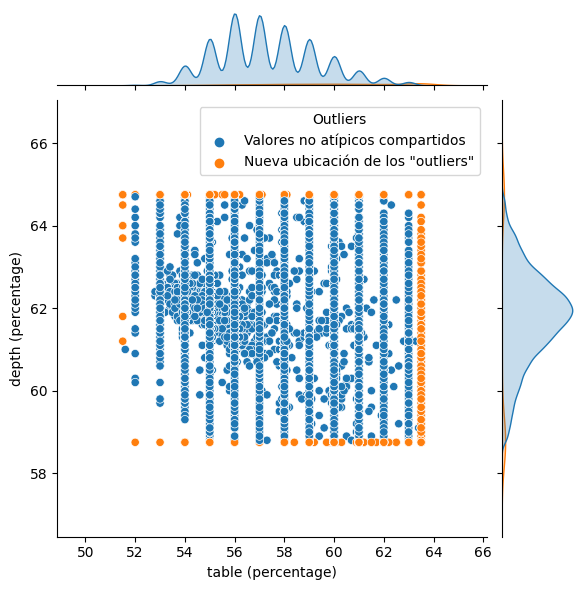

In [166]:
# Con esa información, se deduce que la correlación negativa (-0.3) se debe en parte al peso de los "outliers" de mayor tabla y menor profundidad, que son más numerosos
# Esa correlación es especialmente importante porque es la única lo bastante alta como para vincular las dos variables, si el modelo acaba trabajando con una de ellas
# Con tal de preservar esa correlación, es razonable imputar los valores atípicos a los máximos y mínimos de los no atípicos
for column in ['depth (percentage)', 'table (percentage)']:
    q3, q1 = np.percentile(df_practice[column], [75, 25])
    iqr = q3 - q1
    df_practice.loc[df_practice[column] > q3 + 1.5*iqr, column] = q3 + 1.5*iqr
    df_practice.loc[df_practice[column] < q1 - 1.5*iqr, column] = q1 - 1.5*iqr

df_practice.loc[df_practice['Outliers'] == 'Valores atípicos compartidos', 'Outliers'] = 'Valores atípicos no compartidos'
df_practice.loc[df_practice['Outliers'] == 'Valores atípicos no compartidos', 'Outliers'] = 'Nueva ubicación de los "outliers"'

sns.jointplot(data=df_practice, x='table (percentage)', y='depth (percentage)', hue='Outliers')
plt.show()


correlación: -0.30201465184422965


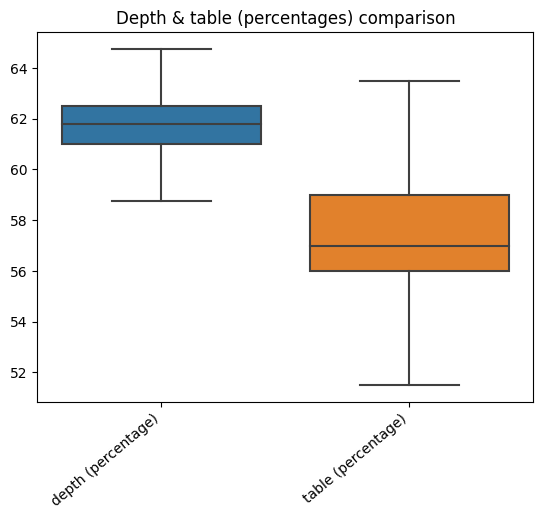

In [167]:
# La correlación inversa se mantendría en la misma cifra y ya no habría valores atípicos
df_practice = df_practice.drop(columns='Outliers')

print(f"correlación: {df_practice['depth (percentage)'].corr(df_practice['table (percentage)'])}")

ax = sns.boxplot(df_practice[['depth (percentage)', 'table (percentage)']])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title('Depth & table (percentages) comparison')
plt.show()


## cut quality & table (percentage)

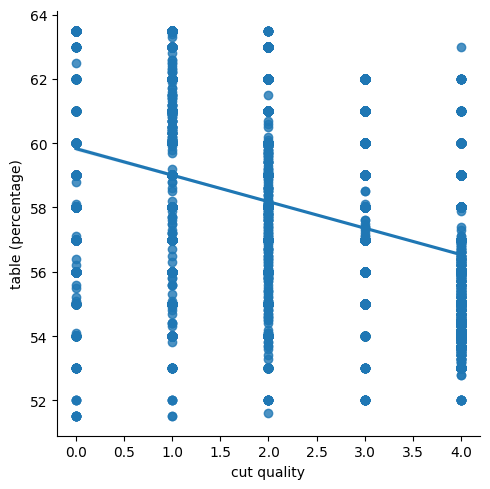

In [168]:
# Las variables "cut quality" y "table (percentage)", que es el tamaño de la parte plana en relación con su diámetro, tienen una alta correlación inversa
# Los valores de "table (percentage)" parecen concentrarse en un punto a medida que aumenta la calidad hasta desplazarse finalmente hacia valores negativos con los mejor cortados
# Con lo visto en el análisis univariante de "cut quality" y en la gráfica, se propone lo siguiente:
# que haya pocos valores de calidad menor influye en que la concentración de los números más altos sea superior, lo que hace caer la correlación
sns.lmplot(data=df_practice, x='cut quality', y='table (percentage)')
plt.show()


In [169]:
# Para probarlo, hay que fabricar más valores de "table (percentage)"" que tengan -1.0 de "cut quality"
# Para ello, como no es deseable que el resultado se aleje mucho la predicción de lo que ya existe y se dispone de pocos datos, se itera con un modelo de k vecinos
# Se procura que el número de valores resultantes se aceque a los 20000 que tiene el corte de mayor calidad
lower_quality = df_practice['cut quality'].min()

lower_cut = df_practice[df_practice['cut quality'] == lower_quality]

new_cut = list(df_practice['cut quality'])
new_table = list(df_practice['table (percentage)'])
for _ in range(40):
    X_train, X_test, y_train, y_test = train_test_split(lower_cut.drop(columns='table (percentage)'), lower_cut['table (percentage)'], train_size=0.6, random_state=random.randint(1, 10000))
    vecinos = KNeighborsRegressor()
    vecinos.fit(X_train, y_train)
    y_pred = vecinos.predict(X_test).tolist()
    new_cut += [lower_quality] * len(y_pred)
    new_table += y_pred
cut_table_comparison = pd.DataFrame({'cut quality': new_cut, 'table (percentage)': new_table})

print(f"Nº de valores -1.0 originales: {len(df_practice[df_practice['cut quality'] == lower_quality])}")
print(f"Nº de valores -1.0 tras la fabricación: {len(cut_table_comparison[cut_table_comparison['cut quality'] == lower_quality])}")


Nº de valores -1.0 originales: 1193
Nº de valores -1.0 tras la fabricación: 20313


                    cut quality  table (percentage)
cut quality            1.000000           -0.389264
table (percentage)    -0.389264            1.000000


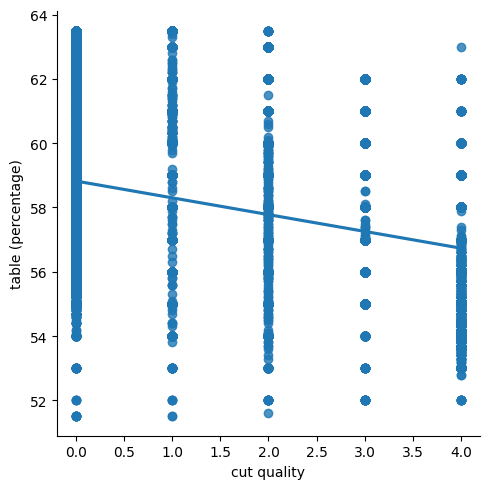

In [171]:
# Se han creado muchísimos valores artificialmente, y, sin embargo, no hay grandes cambios
# La correlación y la recta de regresión solo cambian ligeramente
print(cut_table_comparison.corr())

sns.lmplot(data=cut_table_comparison, x='cut quality', y='table (percentage)')
plt.show()


# Estandarización

In [172]:
# Algunas columnas tienen valores muy altos
# Habrá que aplicar una estandarización a todos los "dataframes" en algún punto
df_practice.head()


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
0,-1.203973,3.0,6.0,1.0,62.4,58.0,1.460938,1.453953,0.985817,6.353
1,0.009950,4.0,5.0,5.0,62.7,56.0,1.859418,1.865629,1.396245,9.183
2,-0.328504,4.0,4.0,3.0,61.8,59.0,1.742219,1.747459,1.264127,7.983
3,0.076961,2.0,3.0,1.0,63.2,57.0,1.877937,1.871802,1.415853,8.371
4,-1.021651,3.0,3.0,4.0,62.3,59.0,1.504077,1.515127,1.036737,6.588


In [173]:
# Para el caso, solo se hace con la de práctica
scaler = MinMaxScaler()
df_practice = pd.DataFrame(scaler.fit_transform(df_practice.values), columns=df_practice.columns, index=df_practice.index)

df_practice.head()


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
0,0.131562,0.75,1.000000,0.142857,0.608333,0.541667,0.139135,0.143538,0.168096,0.139581
1,0.525447,1.00,0.833333,0.714286,0.658333,0.375000,0.522743,0.534767,0.552789,0.837485
2,0.415628,1.00,0.666667,0.428571,0.508333,0.625000,0.409919,0.422466,0.428955,0.541554
3,0.547190,0.50,0.500000,0.142857,0.741667,0.458333,0.540571,0.540633,0.571168,0.637238
4,0.190721,0.75,0.500000,0.571429,0.591667,0.625000,0.180665,0.201674,0.215823,0.197534


# Observaciones finales

In [174]:
# Los números quedarían pequeños; ninguna columna con valores excesivamente altos (todos alrededor del 0)
df_practice.head()


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
0,0.131562,0.75,1.000000,0.142857,0.608333,0.541667,0.139135,0.143538,0.168096,0.139581
1,0.525447,1.00,0.833333,0.714286,0.658333,0.375000,0.522743,0.534767,0.552789,0.837485
2,0.415628,1.00,0.666667,0.428571,0.508333,0.625000,0.409919,0.422466,0.428955,0.541554
3,0.547190,0.50,0.500000,0.142857,0.741667,0.458333,0.540571,0.540633,0.571168,0.637238
4,0.190721,0.75,0.500000,0.571429,0.591667,0.625000,0.180665,0.201674,0.215823,0.197534


In [175]:
# Se borrarían algunas filas respecto a las iniciales
df_practice.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 40435 entries, 0 to 40454
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   weight (carat)        40435 non-null  float64
 1   cut quality           40435 non-null  float64
 2   color quality         40435 non-null  float64
 3   clarity quality       40435 non-null  float64
 4   depth (percentage)    40435 non-null  float64
 5   table (percentage)    40435 non-null  float64
 6   lenght (millimeters)  40435 non-null  float64
 7   width (millimeters)   40435 non-null  float64
 8   depth (millimeters)   40435 non-null  float64
 9   price                 40435 non-null  float64
dtypes: float64(10)
memory usage: 3.4 MB


In [176]:
# Todas las columnas de todos los "dataframes" son numéricas 
# En el de práctica no hay ceros en las variables relacionadas con el tamaño
df_practice.describe()


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
count,40435.000000,40435.000000,40435.000000,40435.000000,40435.000000,40435.000000,40435.000000,40435.000000,40435.000000,40435.000000
mean,0.393569,0.727050,0.567982,0.435521,0.499483,0.494377,0.395088,0.403389,0.410773,0.492390
std,0.190109,0.278957,0.283933,0.235208,0.211866,0.179829,0.186892,0.183141,0.181950,0.250757
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.224907,0.500000,0.333333,0.285714,0.375000,0.375000,0.224573,0.236534,0.245269,0.262392
50%,0.406487,0.750000,0.500000,0.428571,0.508333,0.458333,0.406541,0.415821,0.423645,0.491492
75%,0.534944,1.000000,0.833333,0.571429,0.625000,0.625000,0.540571,0.546464,0.550466,0.689026
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [177]:
df_diamonds[0].describe()


,id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
count,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000
mean,20227.000000,0.797576,2.907477,3.408083,3.048399,61.746377,57.451694,5.729163,5.732896,3.537351,7.783822
std,11678.496907,0.475939,1.116543,1.703529,1.646425,1.436796,2.234569,1.125244,1.154799,0.711002,1.016828
min,0.000000,0.200000,0.000000,0.000000,0.000000,43.000000,44.000000,0.000000,0.000000,0.000000,5.787000
25%,10113.500000,0.400000,2.000000,2.000000,2.000000,61.000000,56.000000,4.710000,4.720000,2.910000,6.851000
50%,20227.000000,0.700000,3.000000,3.000000,3.000000,61.800000,57.000000,5.690000,5.700000,3.520000,7.780000
75%,30340.500000,1.040000,4.000000,5.000000,4.000000,62.500000,59.000000,6.540000,6.540000,4.030000,8.581000
max,40454.000000,5.010000,4.000000,6.000000,7.000000,79.000000,95.000000,10.740000,58.900000,31.800000,9.842000


In [178]:
df_diamonds[1].describe()


,id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters)
count,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000
mean,6742.000000,0.799032,2.893956,3.398962,3.058880,61.758487,57.473652,5.737139,5.739416,3.542883
std,3892.928525,0.468195,1.116752,1.693856,1.649305,1.420037,2.234259,1.111265,1.103297,0.689553
min,0.000000,0.200000,0.000000,0.000000,0.000000,50.800000,43.000000,0.000000,0.000000,0.000000
25%,3371.000000,0.400000,2.000000,2.000000,2.000000,61.100000,56.000000,4.730000,4.740000,2.920000
50%,6742.000000,0.710000,3.000000,3.000000,3.000000,61.900000,57.000000,5.710000,5.720000,3.530000
75%,10113.000000,1.040000,4.000000,5.000000,4.000000,62.500000,59.000000,6.540000,6.540000,4.040000
max,13484.000000,4.130000,4.000000,6.000000,7.000000,79.000000,73.000000,10.140000,10.100000,6.430000


In [179]:
# No hay duplicados en el "dataframe" con el que se va a modelar
df_diamonds[0][df_diamonds[0].duplicated()]


,id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price


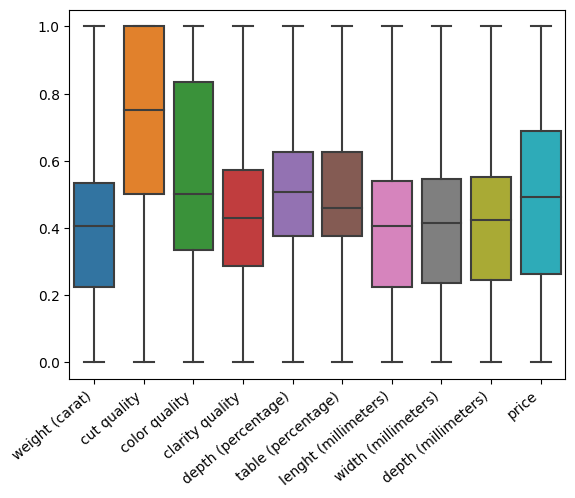

In [180]:
# Con lo aplicado en el "dataframe" de práctica, no hay valores atípicos
ax = sns.boxplot(df_practice)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()


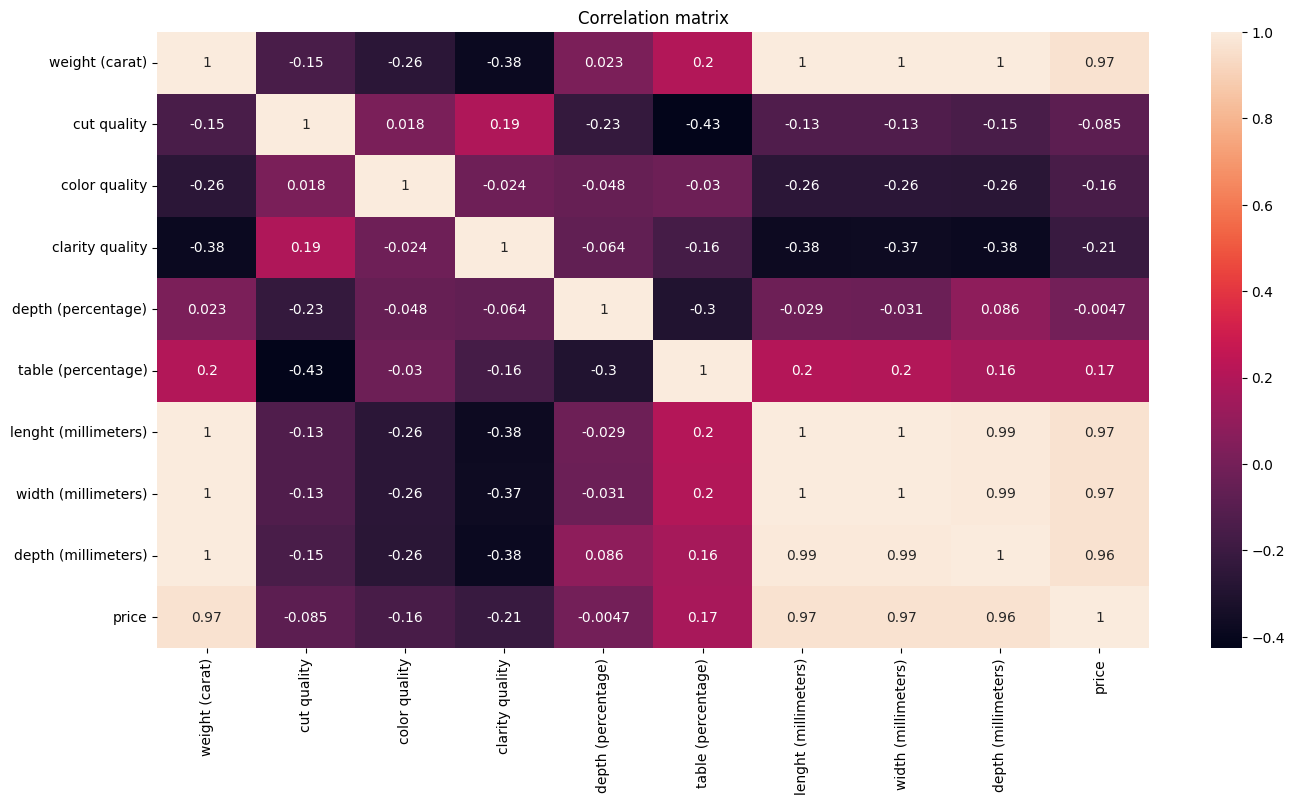

In [181]:
# La correlación ha cambiado muy poco debido al tratamiento de los datos
# La tendencia general es casi igual y se han incorporado las variables que eran categóricas
plt.rc("figure", figsize=(16, 8))

corr = df_practice.corr(numeric_only=True)
sns.heatmap(corr, annot=True)
plt.title('Correlation matrix')
plt.show()


In [182]:
plt.rc("figure", figsize=(6.4, 4.8))


# Exportación

In [183]:
df_diamonds[0].head()


,id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
0,0,0.30,3.0,6.0,1.0,62.4,58.0,4.31,4.28,2.68,6.353
1,1,1.01,4.0,5.0,5.0,62.7,56.0,6.42,6.46,4.04,9.183
2,2,0.72,4.0,4.0,3.0,61.8,59.0,5.71,5.74,3.54,7.983
3,3,1.08,2.0,3.0,1.0,63.2,57.0,6.54,6.50,4.12,8.371
4,4,0.36,3.0,3.0,4.0,62.3,59.0,4.50,4.55,2.82,6.588


In [184]:
df_diamonds[1].head()


,id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters)
0,0,0.32,4.0,1.0,2.0,60.5,58.0,4.43,4.49,2.70
1,1,1.24,3.0,1.0,2.0,62.9,60.0,6.80,6.74,4.26
2,2,1.66,3.0,6.0,2.0,62.0,59.0,7.55,7.60,4.70
3,3,0.75,3.0,6.0,1.0,60.6,56.0,5.94,5.90,3.59
4,4,1.50,0.0,5.0,1.0,64.8,55.0,7.26,7.15,4.67


In [185]:
# Los "dataframes" están preparado para el modelaje. Los exportamos
df_diamonds[0].to_csv(r'..\data\processed\diamonds_train_1.csv', index=False)
df_diamonds[1].to_csv(r'..\data\processed\diamonds_test_1.csv', index=False)
